In [1]:
import torch
import torch.nn as nn 
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from skimage import io
import time

import warnings
warnings.filterwarnings("ignore")


 ### Veriyi dahil etme 

In [2]:
class Veri(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)  # Değiştirilmiş satır: io.read_image'den io.imread'e
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
        
        if self.transform:
            image = self.transform(image)
            
        return (image, y_label)


### Burdaki fotograf verileri sizde yok ama siz kendi verinizi etiketleyebilirisniz ve bunu csv dosysı şeklinde kaydedebilirsiniz 

###  Veriyi dahil etme 

In [3]:
dataset = Veri(
    csv_file="/Users/abdulbarisoylemez/Documents/Visual Code/Yapay Zeka ve Bilgisayarlı Görü Mühendisi/İsaretDiliCNNtespiti/fotograf_etiketler.csv",
    root_dir="/Users/abdulbarisoylemez/Documents/Visual Code/Bitirme Projesi/kod/data/isaretData",
    transform=transforms.Compose([ 
        transforms.ToTensor(),
        transforms.Resize(size=(64, 64)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
)


In [4]:
dataset

### Veri ön işeleme

In [5]:
total_length = len(dataset)
train_length = 1500  # Eğitim verisi sayısı
test_length = total_length - train_length  # Test verisi sayısı
# veriilerimiz random olarak değişkenlere atalım 
train_set, test_set = torch.utils.data.random_split(dataset, [train_length, test_length])

# DataLoader'ları oluşturmak
train_loader = DataLoader(dataset=train_set, batch_size=1, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=1, shuffle=True)


In [6]:
train_set

In [7]:
test_set

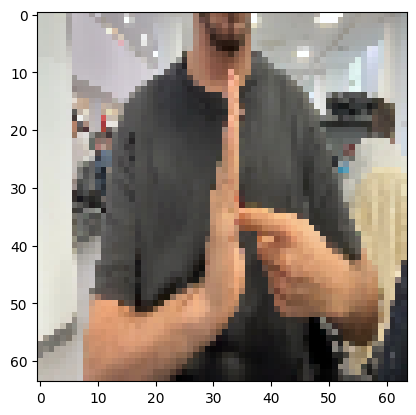

DOT  
torch.Size([1, 3, 64, 64])


In [7]:

import matplotlib.pyplot as plt
import numpy as np

batch_size = 1
classes = ["A", "B", "Bosluk", "C", "D", "DOT", "E", "F", "G", "H", "I", "K", "L", "M", "N", "O", "P", "R", "S", "SPACE", "T", "U", "V", "Y", "Z"]
#classes = [0,1, 2,3, 4, 5, 6, 7,8,9,10,11,12,13,14, 15,16,17, 18, 19,20,21, 22, 23,24]


def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

print(' '.join("%-5s" % classes[labels[j]] for j in range(batch_size)))
print(images.size())

## MODEL MİMARİSİNİ OLUŞTURMA 

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(5, 5))
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(5, 5))
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3))
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5))

        self.max = nn.MaxPool2d(kernel_size=(2, 2))

        self.func = nn.ELU()

        self.fc1 = nn.Linear(in_features=64, out_features=124)
        self.fc2 = nn.Linear(in_features=124, out_features=124)
        self.fc3 = nn.Linear(in_features=124, out_features=100)
        self.fc4 = nn.Linear(in_features=100, out_features=25)

    def forward(self, x):
        x = self.conv1(x)
        x = self.func(x)
        x = self.max(x)

        x = self.conv2(x)
        x = self.func(x)
        x = self.max(x)

        x = self.conv3(x)
        x = self.func(x)
        x = self.max(x)

        x = self.conv4(x)
        x = self.func(x)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.func(x)

        x = self.fc2(x)
        x = self.func(x)

        x = self.fc3(x)
        x = self.func(x)

        x = self.fc4(x)

        return x


### Model eğitimi

In [9]:
start=time.time()
model = Net()

optimizer = torch.optim.Adamax(model.parameters(), lr=0.001)  

error = torch.nn.CrossEntropyLoss()

epoch = 10

for e in range(epoch):  

    for i, (images, labels) in enumerate(train_loader):

        optimizer.zero_grad()  

        tahmin = model(images)

        loss = error(tahmin, labels)

        loss.backward()

        optimizer.step()

        print("Epoch [{}/{}], loss: {:.6f}".format(e, epoch, loss.item())) 

end = time.time()
print("süre:", end - start)


Epoch [0/10], loss: 3.221803
Epoch [0/10], loss: 3.290618
Epoch [0/10], loss: 3.104249
Epoch [0/10], loss: 3.244519
Epoch [0/10], loss: 3.346218
Epoch [0/10], loss: 3.321546
Epoch [0/10], loss: 3.322476
Epoch [0/10], loss: 3.237975
Epoch [0/10], loss: 3.186448
Epoch [0/10], loss: 3.170113
Epoch [0/10], loss: 3.322041
Epoch [0/10], loss: 3.334023
Epoch [0/10], loss: 3.334625
Epoch [0/10], loss: 3.216957
Epoch [0/10], loss: 3.064919
Epoch [0/10], loss: 3.298409
Epoch [0/10], loss: 3.192444
Epoch [0/10], loss: 3.171761
Epoch [0/10], loss: 3.407987
Epoch [0/10], loss: 3.141670
Epoch [0/10], loss: 3.277075
Epoch [0/10], loss: 3.012626
Epoch [0/10], loss: 3.359258
Epoch [0/10], loss: 3.340519
Epoch [0/10], loss: 3.096022
Epoch [0/10], loss: 3.326231
Epoch [0/10], loss: 3.239787
Epoch [0/10], loss: 3.390851
Epoch [0/10], loss: 3.150268
Epoch [0/10], loss: 3.280045
Epoch [0/10], loss: 3.364739
Epoch [0/10], loss: 3.381591
Epoch [0/10], loss: 3.024279
Epoch [0/10], loss: 3.228493
Epoch [0/10], 

### Model testi

In [10]:
def dogruluk(loader,model):
     num_correct=0
     num_samples=0
     model.eval()

     with torch.no_grad():
          for x,y in loader:
               tahmin=model(x)
               _,pred=tahmin.max(1)
               num_correct+=(pred==y).sum()
               num_samples+=pred.size(0)
          print(
               f"got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}"
          )
          model.train()


In [11]:
print("train doğruluk :")
dogruluk(train_loader,model)
print("test doğruluk")
dogruluk(test_loader,model)

train doğruluk :
got 1498 / 1500 with accuracy 99.87
test doğruluk
got 495 / 500 with accuracy 99.00


In [12]:
print(torch.cuda.is_available())


False


" ### Model testi 2  """Adam algoritması"""

In [13]:
"""start=time.time()  ## modeli GPU da çalıştıurmak istedik hata aldık hatalar 
model = Net()

device=torch.device("cuda") # hata
model=model.to(device)# hata
#

#

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  

error = torch.nn.CrossEntropyLoss()

epoch = 10
kayıp_list=[]
count=0
iterasyon=[]
basarı_list=[]
for e in range(epoch):  

    for i, (images, labels) in enumerate(train_loader): 
        images=images.to(device) # hata
        labels=labels.to(device) # hata

        tahmin = model(images.float()) # hata float() sil hata gider

        optimizer.zero_grad() 

        loss = error(tahmin, labels)

        loss.backward()

        optimizer.step()

        count+=1

        if count % 100 ==0:
            total=0
            correct=0
            correct_hata=0

            for images,labels in test_loader:
                
                out=model(images)
                pred=torch.max(out.data,1)[1]
                total+=len(labels)

                correct+=(pred==labels).sum()
                correct_hata+=(pred!=labels).sum()

            dogruluk=100*correct/float(total)
            hata=100*correct_hata/float(total)

            kayıp_list.append(loss.data)
            basarı_list.append(dogruluk)
            iterasyon.append(count)
        
        if count%100==0:
            print("iterasyon{}, loss: {},Accuracy: {} % Error: {}%".format(count, loss.data,dogruluk,hata)) 
       
end = time.time()
print("süre:", end - start)
"""

'start=time.time()  ## modeli GPU da çalıştıurmak istedik hata aldık hatalar \nmodel = Net()\n\ndevice=torch.device("cuda") # hata\nmodel=model.to(device)# hata\n#\n\n#\n\noptimizer = torch.optim.Adam(model.parameters(), lr=0.001)  \n\nerror = torch.nn.CrossEntropyLoss()\n\nepoch = 10\nkayıp_list=[]\ncount=0\niterasyon=[]\nbasarı_list=[]\nfor e in range(epoch):  \n\n    for i, (images, labels) in enumerate(train_loader): \n        images=images.to(device) # hata\n        labels=labels.to(device) # hata\n\n        tahmin = model(images.float()) #\xa0hata float() sil hata gider\n\n        optimizer.zero_grad() \n\n        loss = error(tahmin, labels)\n\n        loss.backward()\n\n        optimizer.step()\n\n        count+=1\n\n        if count % 100 ==0:\n            total=0\n            correct=0\n            correct_hata=0\n\n            for images,labels in test_loader:\n                \n                out=model(images)\n                pred=torch.max(out.data,1)[1]\n               

LRazaltma

In [14]:
start=time.time()  ## modeli GPU da çalıştıurmak istedik hata aldık hatalar 
model = Net()



optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  

error = torch.nn.CrossEntropyLoss()

from torch.optim.lr_scheduler import StepLR # Kademeli Learning Rate azaltma 
Lr=StepLR(optimizer,step_size=2,gamma=0.7)

epoch = 8
kayıp_list=[]
count=0
iterasyon=[]
basarı_list=[]
for e in range(epoch):  
    Lr.step()
    print(" epoch:",epoch, "  Lr:",Lr.get_lr)

    for i, (images, labels) in enumerate(train_loader): 
        

        tahmin = model(images) 

        optimizer.zero_grad() 

        loss = error(tahmin, labels)

        loss.backward()

        optimizer.step()

        count+=1

        if count % 100 ==0:
            total=0
            correct=0
            correct_hata=0

            for images,labels in test_loader:
                
                out=model(images)
                pred=torch.max(out.data,1)[1]
                total+=len(labels)

                correct+=(pred==labels).sum()
                correct_hata+=(pred!=labels).sum()

            dogruluk=100*correct/float(total)
            hata=100*correct_hata/float(total)

            kayıp_list.append(loss.data)
            basarı_list.append(dogruluk)
            iterasyon.append(count)
        
        if count%100==0:
            print("iterasyon{}, loss: {},Accuracy: {} % Error: {}%".format(count, loss.data,dogruluk,hata)) 
       
end = time.time()
print("süre:", end - start)


 epoch: 8   Lr: <bound method StepLR.get_lr of <torch.optim.lr_scheduler.StepLR object at 0x173065250>>
iterasyon100, loss: 2.681169033050537,Accuracy: 17.600000381469727 % Error: 82.4000015258789%
iterasyon200, loss: 0.5613243579864502,Accuracy: 46.20000076293945 % Error: 53.79999923706055%
iterasyon300, loss: 2.739583969116211,Accuracy: 53.599998474121094 % Error: 46.400001525878906%
iterasyon400, loss: 0.057146307080984116,Accuracy: 64.19999694824219 % Error: 35.79999923706055%
iterasyon500, loss: 0.020579621195793152,Accuracy: 72.80000305175781 % Error: 27.200000762939453%
iterasyon600, loss: 0.13388299942016602,Accuracy: 67.5999984741211 % Error: 32.400001525878906%
iterasyon700, loss: 0.3984687030315399,Accuracy: 70.19999694824219 % Error: 29.799999237060547%
iterasyon800, loss: 0.9757299423217773,Accuracy: 73.19999694824219 % Error: 26.799999237060547%
iterasyon900, loss: 1.9614280462265015,Accuracy: 75.5999984741211 % Error: 24.399999618530273%
iterasyon1000, loss: 0.5074238777

## MODELİ KAYDETME 

In [15]:
torch.save(model,"ModelDil.pth")  # Modelin tamamını kaydetik

In [16]:
torch.save(model.state_dict(),"ModelDilAgirlik.pth") # Modelin ağırlıklarını kaydetik

#### Kaydetiğimiz modleimizi yükliyelim

In [17]:
Modelyükle=torch.load("ModelDil.pth")

##### modelin ağırlıklarına bakalım 

In [18]:
modelAgirl=Net()
modelAgirl.load_state_dict(torch.load("ModelDilAgirlik.pth"))
modelAgirl.eval()

Net(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (max): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (func): ELU(alpha=1.0)
  (fc1): Linear(in_features=64, out_features=124, bias=True)
  (fc2): Linear(in_features=124, out_features=124, bias=True)
  (fc3): Linear(in_features=124, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=25, bias=True)
)

##### Ağırlıklı modelin dpğruluğu

In [19]:
def dogruluk(loader,model):
     num_correct=0
     num_samples=0
     model.eval()

     with torch.no_grad():
          for x,y in loader:
               tahmin=model(x)
               _,pred=tahmin.max(1)
               num_correct+=(pred==y).sum()
               num_samples+=pred.size(0)
          print(
               f"got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}"
          )
          model.train()


In [20]:
print("train doğruluk :")
dogruluk(train_loader,modelAgirl)
print("test doğruluk")
dogruluk(test_loader,modelAgirl)

train doğruluk :
got 1500 / 1500 with accuracy 100.00
test doğruluk
got 496 / 500 with accuracy 99.20


#### Genel modelin doğruluğuna bakalım

In [21]:
def dogruluk(loader,model):
     num_correct=0
     num_samples=0
     model.eval()

     with torch.no_grad():
          for x,y in loader:
               tahmin=model(x)
               _,pred=tahmin.max(1)
               num_correct+=(pred==y).sum()
               num_samples+=pred.size(0)
          print(
               f"got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}"
          )
          model.train()


In [22]:
print("train doğruluk :")
dogruluk(train_loader,Modelyükle)
print("test doğruluk")
dogruluk(test_loader,Modelyükle)

train doğruluk :
got 1500 / 1500 with accuracy 100.00
test doğruluk
got 496 / 500 with accuracy 99.20


### SUMMARY

In [23]:
from torchsummary import summary
summary(model,input_size=(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 60, 60]             608
               ELU-2            [-1, 8, 60, 60]               0
         MaxPool2d-3            [-1, 8, 30, 30]               0
            Conv2d-4           [-1, 16, 26, 26]           3,216
               ELU-5           [-1, 16, 26, 26]               0
         MaxPool2d-6           [-1, 16, 13, 13]               0
            Conv2d-7           [-1, 32, 11, 11]           4,640
               ELU-8           [-1, 32, 11, 11]               0
         MaxPool2d-9             [-1, 32, 5, 5]               0
           Conv2d-10             [-1, 64, 1, 1]          51,264
              ELU-11             [-1, 64, 1, 1]               0
           Linear-12                  [-1, 124]           8,060
              ELU-13                  [-1, 124]               0
           Linear-14                  [

### LOSS görseleştirem 

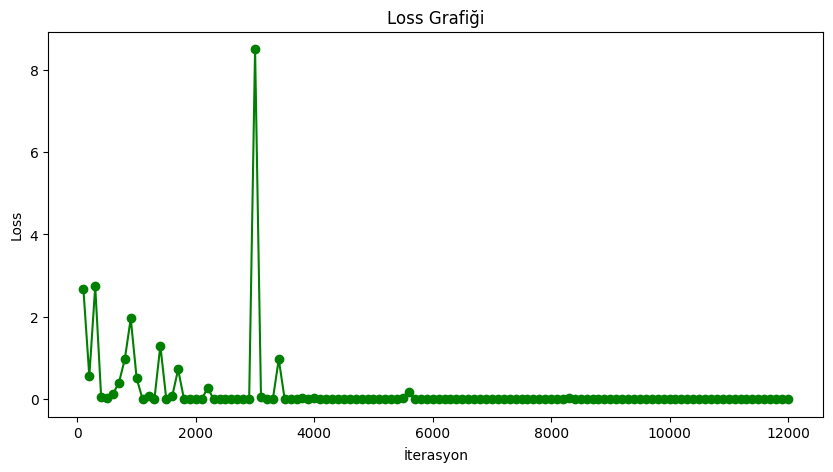

In [24]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10,5))
plt.title("Loss Grafiği")
plt.plot(iterasyon,kayıp_list,"-o",color="g")

plt.xlabel("İterasyon")
plt.ylabel("Loss")

plt.show()

### Accuracy Grafiği

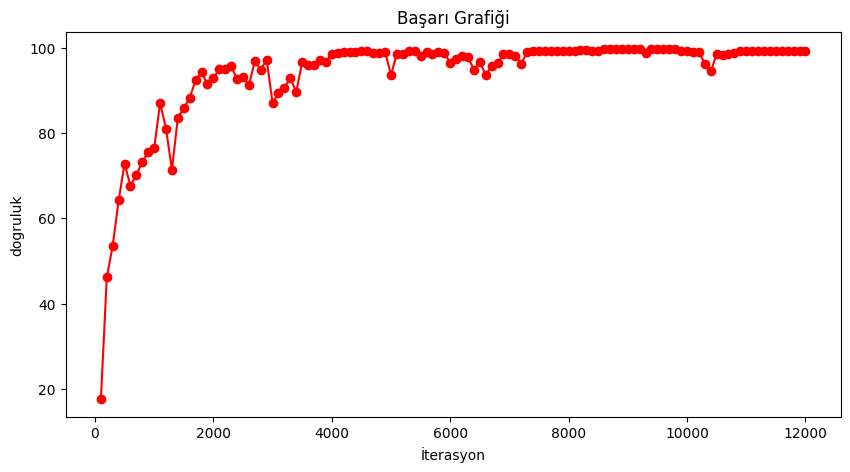

In [25]:
plt.figure(figsize=(10,5))
plt.title("Başarı Grafiği")
plt.plot(iterasyon,basarı_list,"-o",color="r")

plt.xlabel("İterasyon")
plt.ylabel("dogruluk")

plt.show()

#### Test verisinde tahmin yapalım

In [26]:
cals_name = ["A", "B", "Bosluk", "C", "D", "DOT", "E", "F", "G", "H", "I", "K", "L", "M", "N", "O", "P", "R", "S", "SPACE", "T", "U", "V", "Y", "Z"]


In [27]:
def gorsellestirme (model,image_sayısı=10):
     was_tranining=model.training
     model.eval()
     resimsayısı=0

     with torch.no_grad():
          for i,(images,labels) in enumerate(test_loader):
               output=model(images)
               _,tahmin=torch.max(output,1)
               
               for j in range( images.size()[0]):
                     plt.figure(figsize=(40,30))
                     resimsayısı+=1
                     ax=plt.subplot(image_sayısı//2,2,image_sayısı)
                     ax.axis("off")
                     ax.set_title("Tahmin : {}".format( cals_name[tahmin[j]]))
                     imshow(images.cpu().data[j])

                     if resimsayısı==image_sayısı:
                          model.train(was_tranining)
                          return

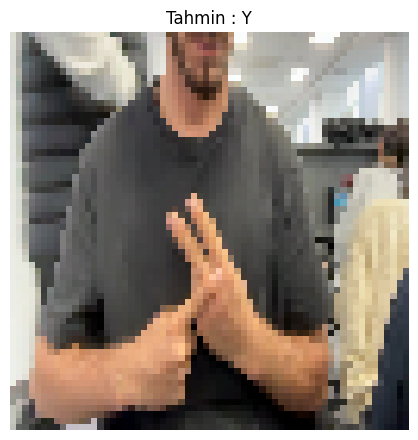

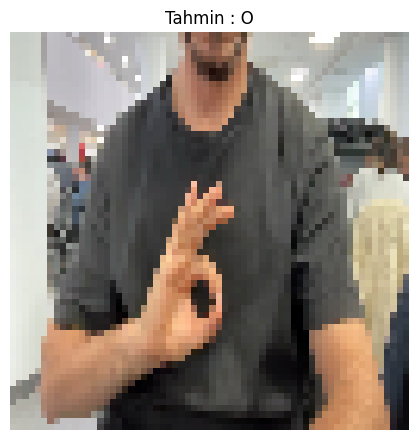

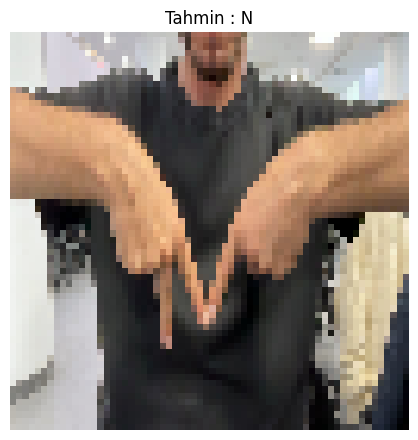

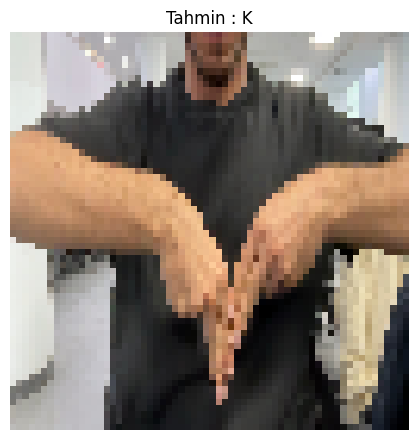

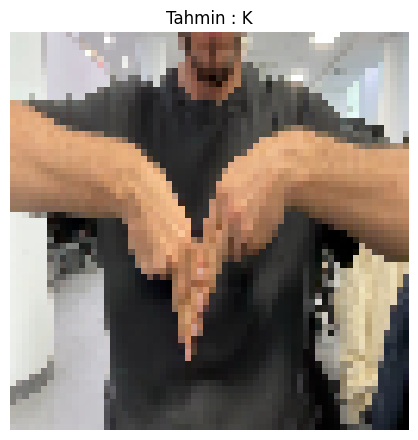

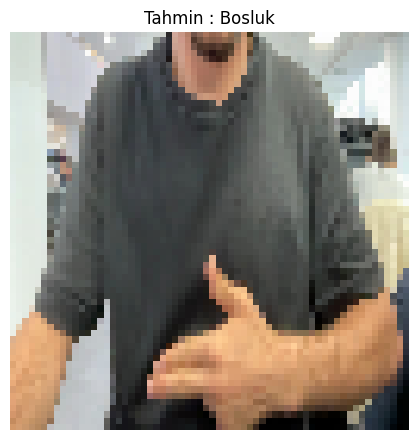

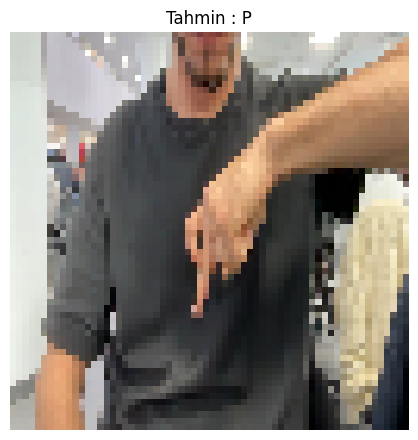

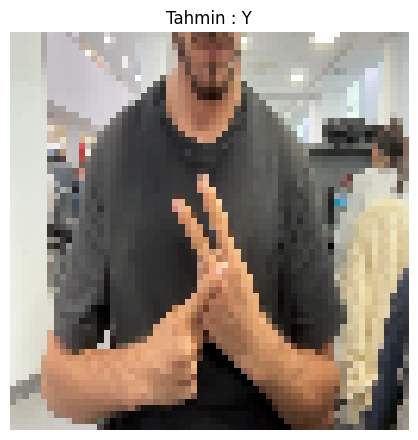

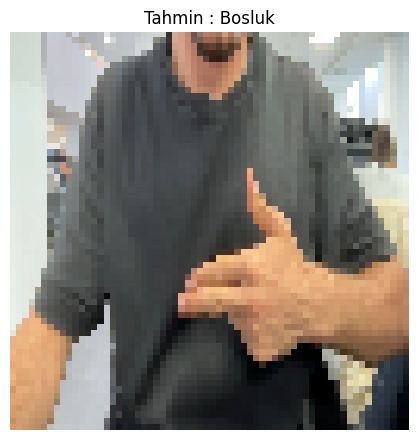

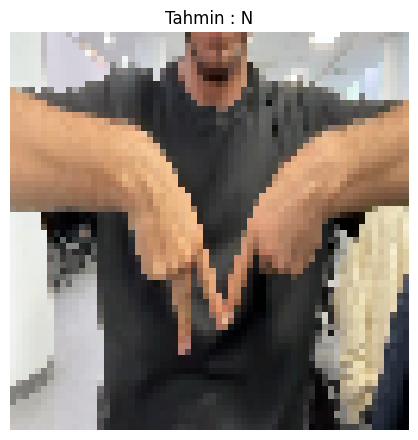

In [28]:
gorsellestirme(model)